# Image classification

## Import TensorFlow and other libraries

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from matplotlib.pyplot import imshow
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.applications.resnet import ResNet50
from keras.preprocessing import image
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


## Download the dataset

In [40]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [65]:
!unzip gdrive/MyDrive/Assignment3/ears.zip

Archive:  gdrive/MyDrive/Assignment3/ears.zip
replace ears/annotations/detection/test.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ears/annotations/detection/test.txt  
 extracting: ears/annotations/detection/test_YOLO_format/0001.txt  
 extracting: ears/annotations/detection/test_YOLO_format/0002.txt  
 extracting: ears/annotations/detection/test_YOLO_format/0003.txt  
 extracting: ears/annotations/detection/test_YOLO_format/0004.txt  
 extracting: ears/annotations/detection/test_YOLO_format/0005.txt  
 extracting: ears/annotations/detection/test_YOLO_format/0006.txt  
 extracting: ears/annotations/detection/test_YOLO_format/0007.txt  
 extracting: ears/annotations/detection/test_YOLO_format/0008.txt  
 extracting: ears/annotations/detection/test_YOLO_format/0009.txt  
 extracting: ears/annotations/detection/test_YOLO_format/0010.txt  
 extracting: ears/annotations/detection/test_YOLO_format/0011.txt  
 extracting: ears/annotations/detection/test_YOLO_format/0012.txt  
 e

In [42]:
images_dir = 'ears/'
train_dir = images_dir+'train/'
test_dir = images_dir + 'test/'
annotations_id = images_dir + 'annotations/recognition/ids.csv'

In [43]:
import glob
import shutil

def get_annotations(annot_f):
  d = {}
  with open(annot_f) as f:
      lines = f.readlines()
      for line in lines:
          (key, val) = line.split(',')
          d[key] = int(val)
  return d

cla_d = get_annotations(annotations_id)
im_list = sorted(glob.glob(train_dir + '*.png', recursive=True))
im_list_test = sorted(glob.glob(test_dir + '*.png', recursive=True))
y=[]
for im_name in im_list:
  y.append(cla_d['/'.join(im_name.split('/')[-2:])])

classes = np.unique(sorted(y))
for img_class in classes:
  os.mkdir(train_dir+str(img_class))
  os.mkdir(test_dir+str(img_class))

for im_name in im_list:
  shutil.move(train_dir+im_name.split('/')[-1:][0], train_dir+str(cla_d['/'.join(im_name.split('/')[-2:])])+"/"+im_name.split('/')[-1:][0])

for im_name in im_list_test:
  shutil.move(test_dir+im_name.split('/')[-1:][0], test_dir+str(cla_d['/'.join(im_name.split('/')[-2:])])+"/"+im_name.split('/')[-1:][0])

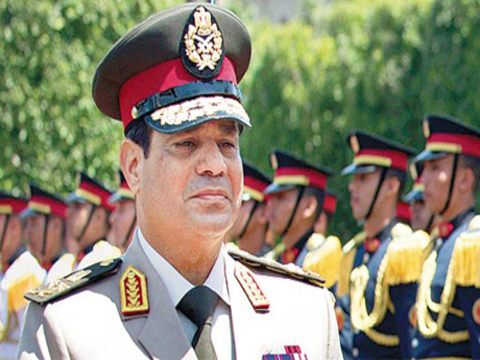

In [44]:
train_data_dir = pathlib.Path(train_dir)
ear_1 = list(train_data_dir.glob('1/*'))
PIL.Image.open(str(ear_1[0]))

# Load data


Define some parameters for the loader:

In [45]:
batch_size = 32
img_height = 64
img_width = 64 

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [46]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 750 files belonging to 100 classes.
Using 600 files for training.
Found 750 files belonging to 100 classes.
Using 150 files for validation.


## Visualize the data

Here are the first nine images from the training dataset:

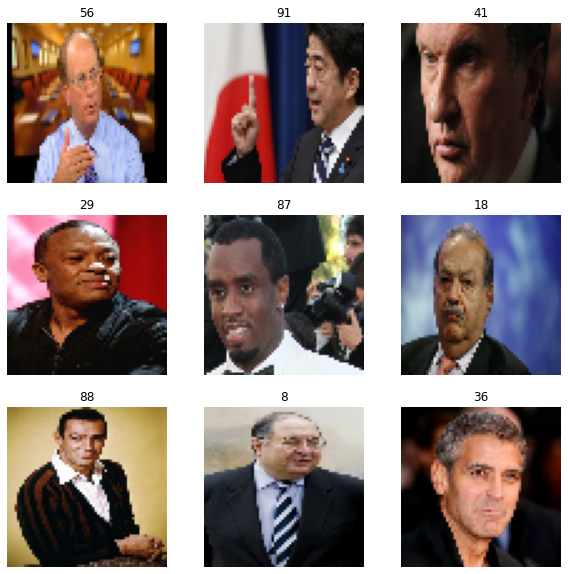

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    class_names = train_ds.class_names
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to `Model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [48]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 64, 64, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [49]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [50]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [51]:
train_normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_normalized_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [52]:
image_batch, labels_batch = next(iter(train_normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.99613976


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

# Create the model (Resnet50)

In [53]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [54]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [55]:
def ResNet50(input_shape, classes):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [56]:
model = ResNet50(input_shape = (img_height, img_width, 3), classes = len(class_names))
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [57]:
epochs = 20
history = model.fit(train_normalized_ds, validation_data = val_normalized_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


19/19 [==============================] - 8s 150ms/step - loss: 7.4962 - accuracy: 0.0050 - val_loss: 4.7208 - val_accuracy: 0.0133
Epoch 2/20
19/19 [==============================] - 1s 64ms/step - loss: 5.9922 - accuracy: 0.0133 - val_loss: 4.6786 - val_accuracy: 0.0067
Epoch 3/20
19/19 [==============================] - 1s 60ms/step - loss: 5.1756 - accuracy: 0.0367 - val_loss: 4.6784 - val_accuracy: 0.0133
Epoch 4/20
19/19 [==============================] - 1s 61ms/step - loss: 4.4921 - accuracy: 0.1617 - val_loss: 4.7348 - val_accuracy: 0.0000e+00
Epoch 5/20
19/19 [==============================] - 1s 60ms/step - loss: 2.7334 - accuracy: 0.5917 - val_loss: 4.7759 - val_accuracy: 0.0000e+00
Epoch 6/20
19/19 [==============================] - 1s 60ms/step - loss: 1.4124 - accuracy: 0.8183 - val_loss: 4.9344 - val_accuracy: 0.0067
Epoch 7/20
19/19 [==============================] - 1s 60ms/step - loss: 1.1877 - accuracy: 0.8400 - val_loss: 5.0240 - val_accuracy: 0.0133
Epoch 8/20
19/1

## Visualize training results

Create plots of loss and accuracy on the training and validation sets:

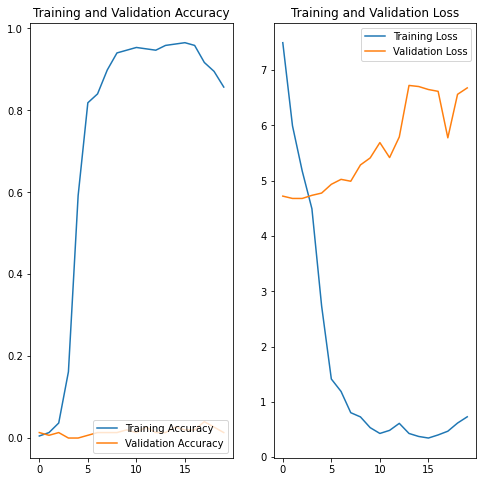

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [59]:
# loss and accuracy metrics
score = model.evaluate_generator(val_normalized_ds, 105)

print ("%s: %.2f%%" % (model.metrics_names[0], score[0]*100))
print ("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

loss: 667.85%
accuracy: 1.33%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

Input image shape: (1, 64, 64, 3)
0.0


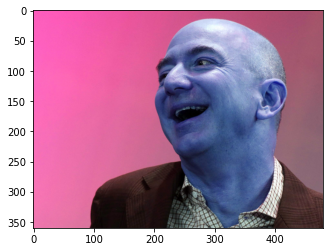

In [66]:
import cv2

img_path = test_dir + '0100.png'
img = image.load_img(img_path, target_size=(img_height, img_width))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = cv2.imread(img_path)
imshow(my_image)
print(model.predict(x)[0][0])

In [72]:
y_preds = []
for img in im_list_test:
  name_img = img.split('/')[-1:][0]
  img_path = test_dir + name_img
  img = image.load_img(img_path, target_size=(img_height, img_width))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  result = model.predict(x)[0][0]
  y_preds.append(result)

In [85]:
y_true = []
for im_name in im_list_test:
  y_true.append(cla_d['/'.join(im_name.split('/')[-2:])])